In [1]:
import time as t
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit.visualization import *
import qiskit_machine_learning as qml
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    CrossEntropyLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [12]:
epochs = 10  # Set number of epochs
filt = [0,1,3,4,8]
# filt = None

if filt==None: filt = [i for i in range(0,10)]

qubits = len(filt)
n_train = 200*len(filt)
n_test = int(n_train/10);

print(
f'using {qubits} Qubits @{n_train} datapoints: {filt} for {epochs} epochs'
)

using 5 Qubits @1000 datapoints: [0, 1, 3, 4, 8] for 10 epochs


In [13]:
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.array([], dtype=int)
for label in filt:
    idx = np.append(idx, np.where(X_train.targets == label)[0][:n_train])
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=32, shuffle=True)


X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))
idx = np.array([], dtype=int)
for label in filt:
    idx = np.append(idx, np.where(X_test.targets == label)[0][:n_test])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [14]:
# Define and create QNN
def create_qnn(qubits):
    feature_map = qiskit.circuit.library.ZZFeatureMap(qubits)
    ansatz = qiskit.circuit.library.EfficientSU2(
                            qubits, su2_gates=['rx', 'ry', 'rz'], 
                            entanglement='circular', reps=1
    )
    qc = qiskit.circuit.QuantumCircuit(qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    
#     print(f"Circuit Depth {qc.depth()}", qc)
    transpiled = qiskit.compiler.transpile(qc)
    print(transpiled)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = qml.neural_networks.EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn

qnn4 = create_qnn(qubits)

     ┌─────────────────────────────────────────┐»
q_0: ┤0                                        ├»
     │                                         │»
q_1: ┤1                                        ├»
     │                                         │»
q_2: ┤2 ZZFeatureMap(x[0],x[1],x[2],x[3],x[4]) ├»
     │                                         │»
q_3: ┤3                                        ├»
     │                                         │»
q_4: ┤4                                        ├»
     └─────────────────────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                         ├
«     │                                                     

In [15]:
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 6, kernel_size=3)
        self.conv2 = Conv2d(6, 16, kernel_size=3)
        self.conv3 = Conv2d(16, qubits, kernel_size=3) # outputs 1x10
        self.dropout = Dropout2d()
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        self.fc3 = Linear(1, 10) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return x; 

model4 = Net(qnn4)
print(model4)
print(model4(torch.randn(1,1,28,28))) # Just testing

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 5, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=10, bias=True)
)
tensor([[ 0.4473, -0.2402,  0.2926, -0.9824, -0.2031, -0.3259, -0.9497, -0.9398,
         -0.6205,  0.4118]], grad_fn=<AddmmBackward0>)


In [ ]:
# Define model, optimizer, and loss function
optimizer = Adam(model4.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)

loss_func = CrossEntropyLoss()

# Start training
loss_list = [2.3]  # Store loss history
model4.train()  # Set model to training mode

itrs = len(train_loader)
logspan = int(itrs*12/100) # 12%

print(f"Running training for {qubits} Qubits @{itrs} itrs/epoch")

In [17]:
for epoch in range(epochs):
    total_loss = []
    times = []
    now = t.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        z = t.time()
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
        z = t.time() - z;
        if ((batch_idx%(logspan))==0): print(f"{int(z)*logspan} sec/{logspan}itrs")
    
    scheduler.step()
    end = int((t.time() - now)/60)+1
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Trained [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]), 
          f"in {end} min \t(est. {int((epochs-epoch)*end)} min left)")
    
    diff = np.abs(loss_list[-1] - loss_list[-2]) /loss_list[-1]; 
    if diff <= 0.0005: # Early stopping criterial loss diff = 0.1%
        print("Τraining Complete")
        break;

Running training for 5 Qubits @157 itrs/epoch
180 sec/18itrs
162 sec/18itrs
162 sec/18itrs
180 sec/18itrs
162 sec/18itrs
180 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
Trained [10%]	Loss: 1.9230 in 27 min 	(est. 270 min left)
180 sec/18itrs
180 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
Trained [20%]	Loss: 1.6400 in 27 min 	(est. 243 min left)
180 sec/18itrs
180 sec/18itrs
180 sec/18itrs
162 sec/18itrs
180 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
Trained [30%]	Loss: 1.5976 in 27 min 	(est. 216 min left)
180 sec/18itrs
162 sec/18itrs
180 sec/18itrs
180 sec/18itrs
180 sec/18itrs
180 sec/18itrs
180 sec/18itrs
180 sec/18itrs
180 sec/18itrs
Trained [40%]	Loss: 1.5423 in 27 min 	(est. 189 min left)
180 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
162 sec/18itrs
Trained [50%]	Loss: 1.4930 in 27 min 	(est. 162

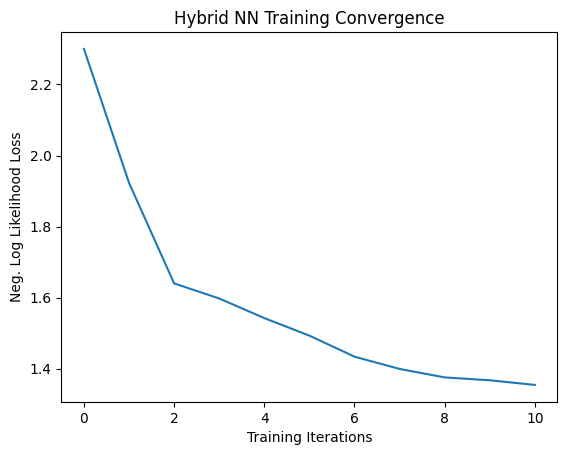

In [18]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [19]:
model4.eval()
with torch.no_grad():
    
    correct = 0
    for (data, target) in test_loader:
        output = model4(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
                sum(total_loss) / len(total_loss),
                correct / len(test_loader) * 100)
            )
    print(f"Perfectly Random would be {int(100/len(filt))}%")

Performance on test data:
	Loss: 1.7869
	Accuracy: 20.0%
Perfectly Random would be 20%


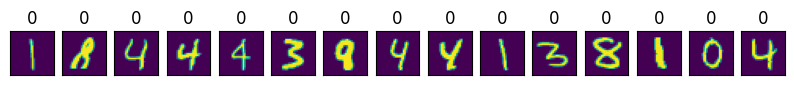

In [20]:
# Plot predicted labels

n_samples_show = 15
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model4.eval()
with no_grad():
    for (data, target) in test_loader:
        if count == n_samples_show:
            break
        output = model4(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="viridis")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("{}".format(pred.item()))

        count += 1

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
html{filter:invert(0.86)}

div.prompt{opacity: 0.5;}

.btn-default{border-color: transparent;}

#header-container{display:none !important;}

div.cell.selected, div.cell.selected.jupyter-soft-selected{border-color: transparent;}
</style>
""")